### IMPORT PACKAGES

In [23]:
# fundamental modules
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib import pyplot
from IPython.display import display, Image
from IPython.core.display import HTML 
# preprocessing
from sklearn.model_selection import train_test_split
# modelling
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.model_selection import GridSearchCV, KFold
from mlfinlab.ensemble import SequentiallyBootstrappedBaggingClassifier
from sklearn.base import clone
import xgboost
import shap
# metrics 
import mlfinlab as ml
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    roc_curve,
    log_loss
    )
# finance packagesb
import mlfinlab as ml
import trademl as tml

### RECAP ML PROCESS

In [27]:
Image(url='https://raw.githubusercontent.com/MislavSag/trademl/master/images/ml_process.jpg')

### GLOBALS

Dok se ne dgovorimo gdje bi (ne)očišćena SPY baza bila pohranjena, učitavat ćemo iz lokalnog foldera.

In [9]:
DATA_PATH = Path('C:/Users/Mislav/algoAItrader/data/spy_store_stat.h5')

### IMPORT

Učitavamo tablicu koju smo čistili posljednji put (micali outliere, stacionirali nestacionarne serije, izbacili nedostajuće vrijednosti). Zadnji puta smo objacsnili sve korake tako da sada samo učitavamo gotovu tablicu.

In [3]:
spy_store_stat = Path(DATA_PATH)
with pd.HDFStore(spy_store_stat) as store:
    spy = store.get('spy_store_stat')
display(spy.head())

,open,high,low,close,volume,vixFirst,vixHigh,vixLow,vixClose,vixVolume,...,fastd_20,fastk_200,fastd_200,fastk_3600,fastd_3600,slowk,slowd,slowk_30,slowd_30,close_orig
TimeBarStart,,,,,,,,,,,,,,,,,,,,,
2003-09-02 14:43:00,3.854955,4.004657,3.847523,4.004120,338100.0,20.28,20.28,20.28,20.28,1.0,...,82.328781,97.387173,70.808231,99.368179,90.450724,84.458281,72.559326,81.814246,79.866729,102.290
2003-09-02 14:44:00,4.002325,4.003246,3.899527,3.984976,374500.0,20.20,20.20,20.20,20.20,1.0,...,84.358645,95.326087,70.911845,98.792135,90.486860,90.584408,82.476351,83.959701,80.368731,102.347
2003-09-02 14:45:00,3.992353,3.946063,3.984013,3.919471,268000.0,19.96,19.96,19.96,19.96,1.0,...,85.078891,93.478261,71.084952,98.314607,90.520130,88.059155,87.700615,85.872692,81.092995,102.330
2003-09-02 14:46:00,3.964396,3.911974,3.942722,3.884583,435300.0,20.01,20.01,20.01,20.01,1.0,...,85.878188,91.304348,71.196164,97.752809,90.552832,82.489762,87.044442,86.458550,81.814407,102.310
2003-09-02 14:47:00,3.852170,3.920927,3.892172,3.900722,120000.0,19.99,19.99,19.99,19.99,1.0,...,87.267077,92.473118,71.356708,98.039216,90.587087,78.836755,83.128557,86.433298,82.589386,102.330


### PRIMARY MODEL

Triple-barrier metoda se sastoji od dva dijela. Prvo konstruira "mentalna" strategija na temleju intuicije (teorije). U ovom slučaju ćemo koristiti jenodstavnu strategiju u kojoj prodajemo dionicu ako je vrijendost VIX-a veća pomićnost presjeka VIX-a iz prošlosti i obrnuto. Ovdje se može testirati i neki drugi modeli. Primjerice napisao sam fukciju za *crossover* strategiju i strategiju na temlelju Bollingerovih traka.

In [4]:
# choose trading strategy
spy = tml.strategies.meta_labeling_primary.vix_change_strategy(spy, vix_window_size=3)
# spy = crossover_strategy(spy, 'close_orig', fast_ma=25, slow_ma=50)
spy.side.value_counts()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


-1.0    1527315
 1.0    1154435
Name: side, dtype: int64

### TRIPLE-BARRIER LABELING

Drugi korak u triple-barrier metodi je identificranje vremena trgovanja na temelju CUSUM filtera i konstruiranje oznaka (*labela*) na temelju smjera investiranja koji smo izračunali u prethodnom koraku.

In [5]:
# Compute daily volatility
daily_vol = ml.util.get_daily_vol(close=spy['close_orig'], lookback=50)

# Apply Symmetric CUSUM Filter and get timestamps for events
cusum_events = ml.filters.cusum_filter(spy['close_orig'],
                                       threshold=daily_vol.mean())

# Compute vertical barrier
vertical_barriers = ml.labeling.add_vertical_barrier(t_events=cusum_events,
                                                    close=spy['close_orig'],
                                                    num_days=10000)

# make triple barriers (if side_prediction arg is omitted, return -1, 0, 1 
# (w/t which touched first))
pt_sl = [1, 1]
min_ret = 0.005
triple_barrier_events = ml.labeling.get_events(
    close=spy['close_orig'],
    t_events=cusum_events,
    pt_sl=pt_sl,
    target=daily_vol,
    min_ret=min_ret,
    num_threads=1,
    vertical_barrier_times=vertical_barriers,
    side_prediction=spy['side'])
display(triple_barrier_events.head(10))

# labels
labels = ml.labeling.get_bins(triple_barrier_events, spy['close_orig'])
display(labels.head(10))
display(labels.side.value_counts())

,t1,trgt,side,pt,sl
2003-09-23 08:43:00,2003-09-24 11:51:00,0.005241,1.0,1,1
2003-10-01 10:02:00,2003-10-01 13:16:00,0.005266,-1.0,1,1
2003-10-01 10:10:00,2003-10-01 13:50:00,0.006510,1.0,1,1
2003-10-01 10:16:00,2003-10-01 13:58:00,0.006645,1.0,1,1
2003-10-01 10:28:00,2003-10-01 13:49:00,0.006283,-1.0,1,1
2003-10-20 08:55:00,2003-10-20 16:35:00,0.006177,1.0,1,1
2003-10-20 09:38:00,2003-10-20 16:04:00,0.005002,-1.0,1,1
2003-10-28 17:03:00,2003-10-28 17:04:00,0.006107,1.0,1,1
2003-10-28 17:04:00,2003-10-30 08:30:00,0.005986,1.0,1,1
2003-12-16 09:15:00,2003-12-16 15:26:00,0.005657,-1.0,1,1


,ret,trgt,bin,side
2003-09-23 08:43:00,-0.005255,0.005241,0,1.0
2003-10-01 10:02:00,-0.005331,0.005266,0,-1.0
2003-10-01 10:10:00,0.006850,0.006510,1,1.0
2003-10-01 10:16:00,0.006742,0.006645,1,1.0
2003-10-01 10:28:00,-0.006609,0.006283,0,-1.0
2003-10-20 08:55:00,0.006315,0.006177,1,1.0
2003-10-20 09:38:00,-0.005054,0.005002,0,-1.0
2003-10-28 17:03:00,0.029360,0.006107,1,1.0
2003-10-28 17:04:00,0.008013,0.005986,1,1.0
2003-12-16 09:15:00,-0.005818,0.005657,0,-1.0


-1.0    11548
 1.0     6873
Name: side, dtype: int64

### RESULTS FROM PRIMARY MODEL

Prikazujemo rezultate primarnog modela

In [6]:
### RESULTS FROM PRIMARY MODEL

# results of primary model
actual = labels['bin']
pred = np.repeat(1, actual.shape[0])
tml.modeling.metrics_summary.display_mental_model_metrics(actual, pred)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      9094
           1       0.51      1.00      0.67      9327

    accuracy                           0.51     18421
   macro avg       0.25      0.50      0.34     18421
weighted avg       0.26      0.51      0.34     18421

Confusion Matrix
[[   0 9094]
 [   0 9327]]
Accuracy
0.5063243037837251


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.


### PREPARE ML SECONDARY MODEL

Pripremamo ML (sekundarni) model. Definiramo varijable X (*featuresi* ili input matrica ili kovarijeble i sl.) i y (oznake smjera - *labels*).

In [7]:
# get data at triple-barrier evetns
X = spy.drop(columns=['close_orig']).reindex(labels.index)  # PROVJERITI OVO. MODA IPAK IDE TRIPPLE-BARRIER INDEX ???
y = labels['bin']
print('X shape: ', X.shape); print('y shape: ', y.shape)
print('y counts:\n', y.value_counts())

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.15, 
                                                    shuffle=False, 
                                                    stratify=None)
print(X_train.shape); print(y_train.shape)
print(X_test.shape); print(y_test.shape)

X shape:  (18421, 300)
y shape:  (18421,)
y counts:
 1    9327
0    9094
Name: bin, dtype: int64
(15657, 300)
(15657,)
(2764, 300)
(2764,)


### SAMPLE WEIGHTS

Prilikom treniranja ML modela, u najvećem broju slučajeva je moguće dodati *sample_weights* argument. Ovaj vektor odražva važnost određenih opažanja prilikom treninga. Primjerice, možemo staviti veću važnost na opažanja (slučajeve) u kojima je prinos bio vrlo nizak ili vrlo visok. Ili možemo staviti veću važnost na prinose koji su ostvareni u skorije vrijeme u odnosu na prinose ostvarene dalje u prošlosti. Ove dvije funkcije niže opisuju upravo ova dva stanja.

In [8]:
return_sample_weights = ml.sample_weights.get_weights_by_return(
    triple_barrier_events.loc[X_train.index],
    spy.loc[X_train.index, 'close_orig'],
    num_threads=1)
time_sample_weights = ml.sample_weights.get_weights_by_time_decay(
    triple_barrier_events.loc[X_train.index],
    spy.loc[X_train.index, 'close_orig'],
    decay=0.5, num_threads=1)

 ### ML (SECONDARY) MODEL

Sada uvodimo ML. ML algoritam će na m reći trebali investirati u određenom trenutku na temleji VIX strategije ili ne treba.

In [ ]:
# parameters for GridSearch
parameters = {'max_depth': [2, 3, 4, 5, 10],
                'n_estimators': [600, 1000, 1400]}

# CV generators
cv_gen_purged = ml.cross_validation.PurgedKFold(
    n_splits=4,
    samples_info_sets=triple_barrier_events.reindex(X_train.index).t1)
rf = RandomForestClassifier(criterion='entropy',
                            max_features=10,
                            min_weight_fraction_leaf=0.05,
                            class_weight='balanced_subsample')
clf = GridSearchCV(rf,
                    param_grid=parameters,
                    scoring='f1',
                    n_jobs=8,
                    cv=cv_gen_purged)
clf.fit(X_train, y_train, sample_weight=time_sample_weights)
depth, n_estimators = clf.best_params_.values()
rf_best = RandomForestClassifier(criterion='entropy',
                                    max_features=1,
                                    min_weight_fraction_leaf=0.05,
                                    max_depth=depth,
                                    n_estimators=n_estimators,
                                    class_weight='balanced_subsample')
rf_best.fit(X_train, y_train, sample_weight=time_sample_weights)
tml.modeling.metrics_summary.display_clf_metrics(
    rf_best, X_train, X_test, y_train, y_test)
tml.modeling.metrics_summary.plot_roc_curve(
    rf_best, X_train, X_test, y_train, y_test)

### FEATURE IMPORTANCE

In [10]:
# mean decreasing impurity
mdi_feature_imp = ml.feature_importance.mean_decrease_impurity(
    rf_best, X_train.columns)

# mean decreasing accuracy
mda_feature_imp = ml.feature_importance.mean_decrease_accuracy(
    rf_best, X_train, y_train, cv_gen_purged,
    scoring=log_loss,
    sample_weight_train=return_sample_weights.values)

# single feature importance
rf_best_ = clone(rf_best)  # seems sfi change learner somehow, and can't use it later
sfi_feature_imp = ml.feature_importance.single_feature_importance(
    rf_best_, X_train, y_train, cv_gen_purged,
    scoring=accuracy_score,
    sample_weight_train=return_sample_weights.values)

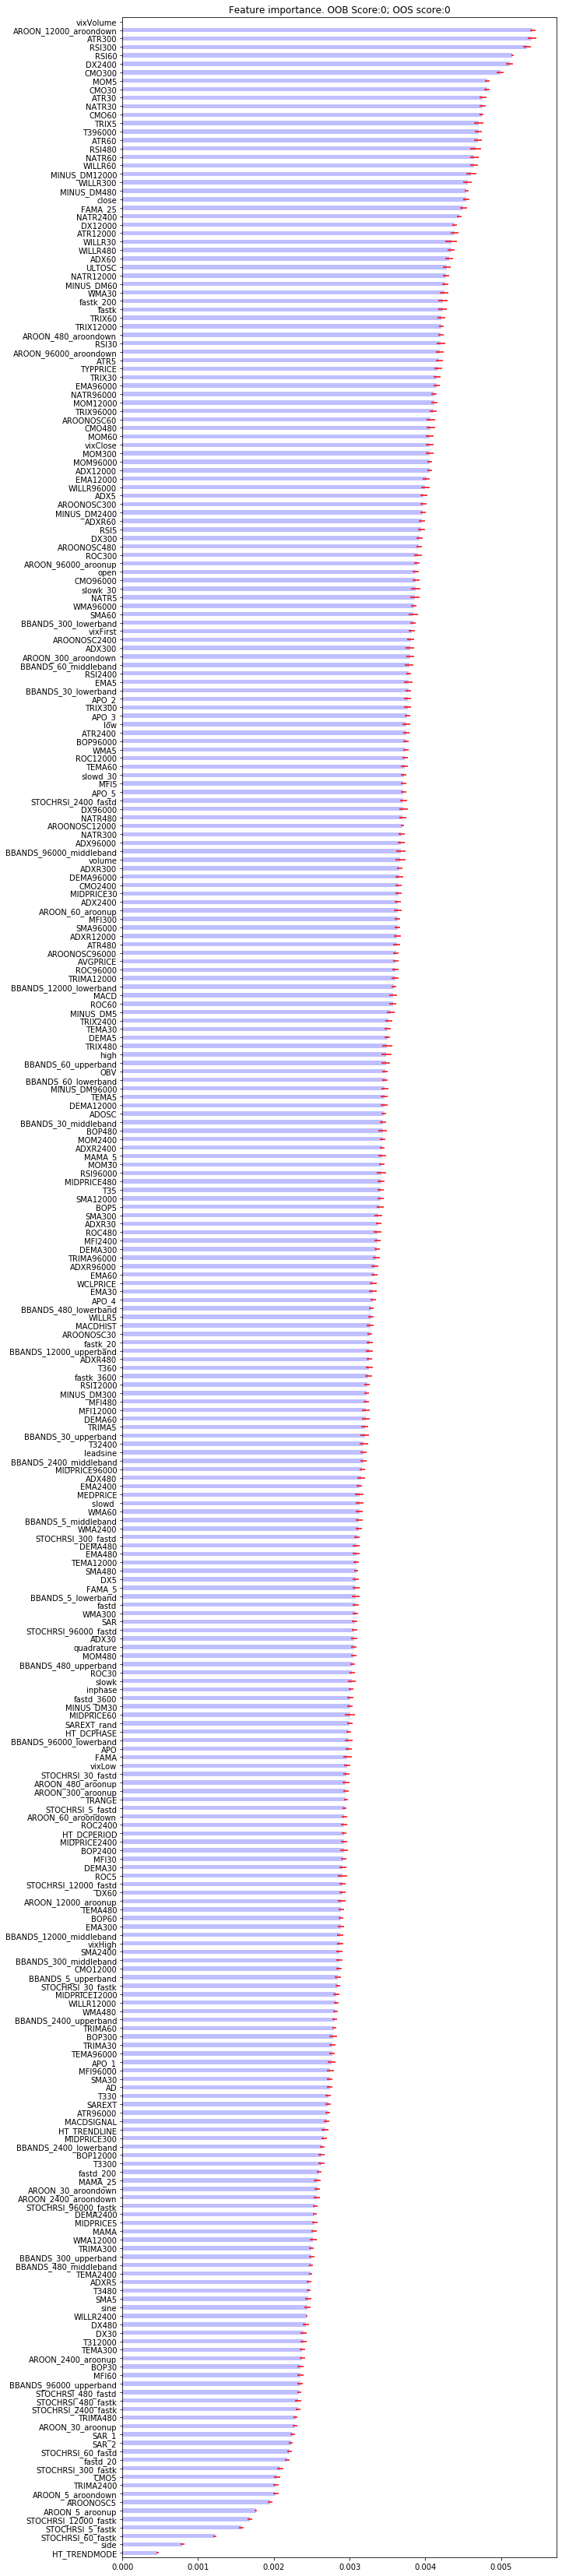

In [11]:
# mean decreasing impurity
ml.feature_importance.plot_feature_importance(
    mdi_feature_imp, 0, 0, save_fig=True,
    output_path='mdi_feat_imp.png')

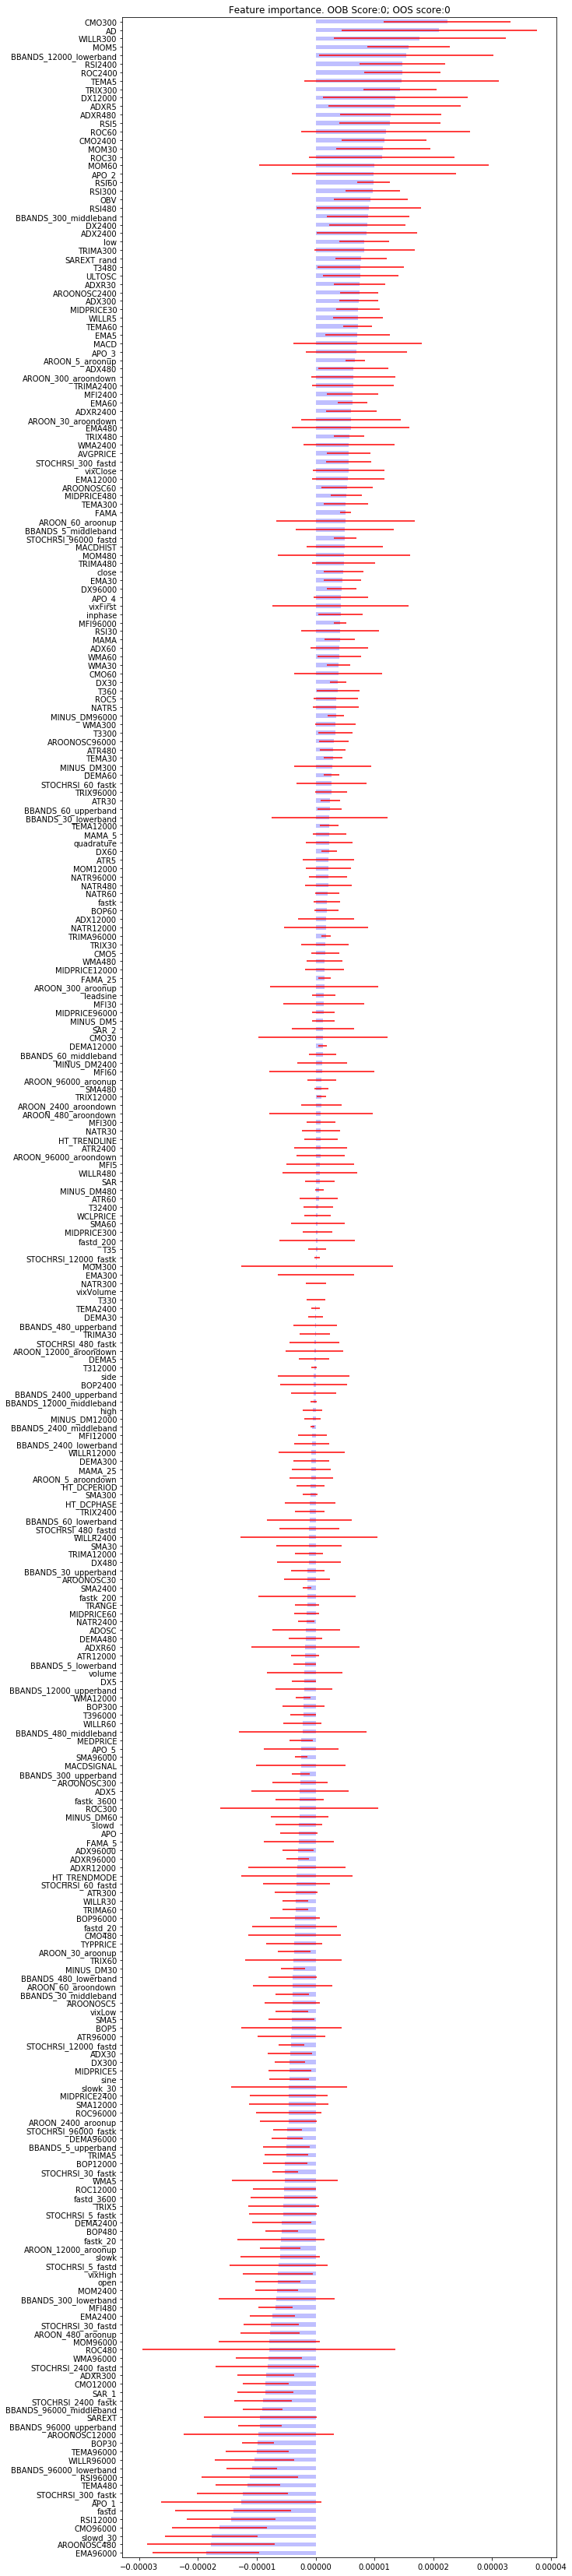

In [12]:
# mean decreasing accuracy
ml.feature_importance.plot_feature_importance(
    mda_feature_imp, 0, 0, save_fig=True,
    output_path='mda_feat_imp.png')

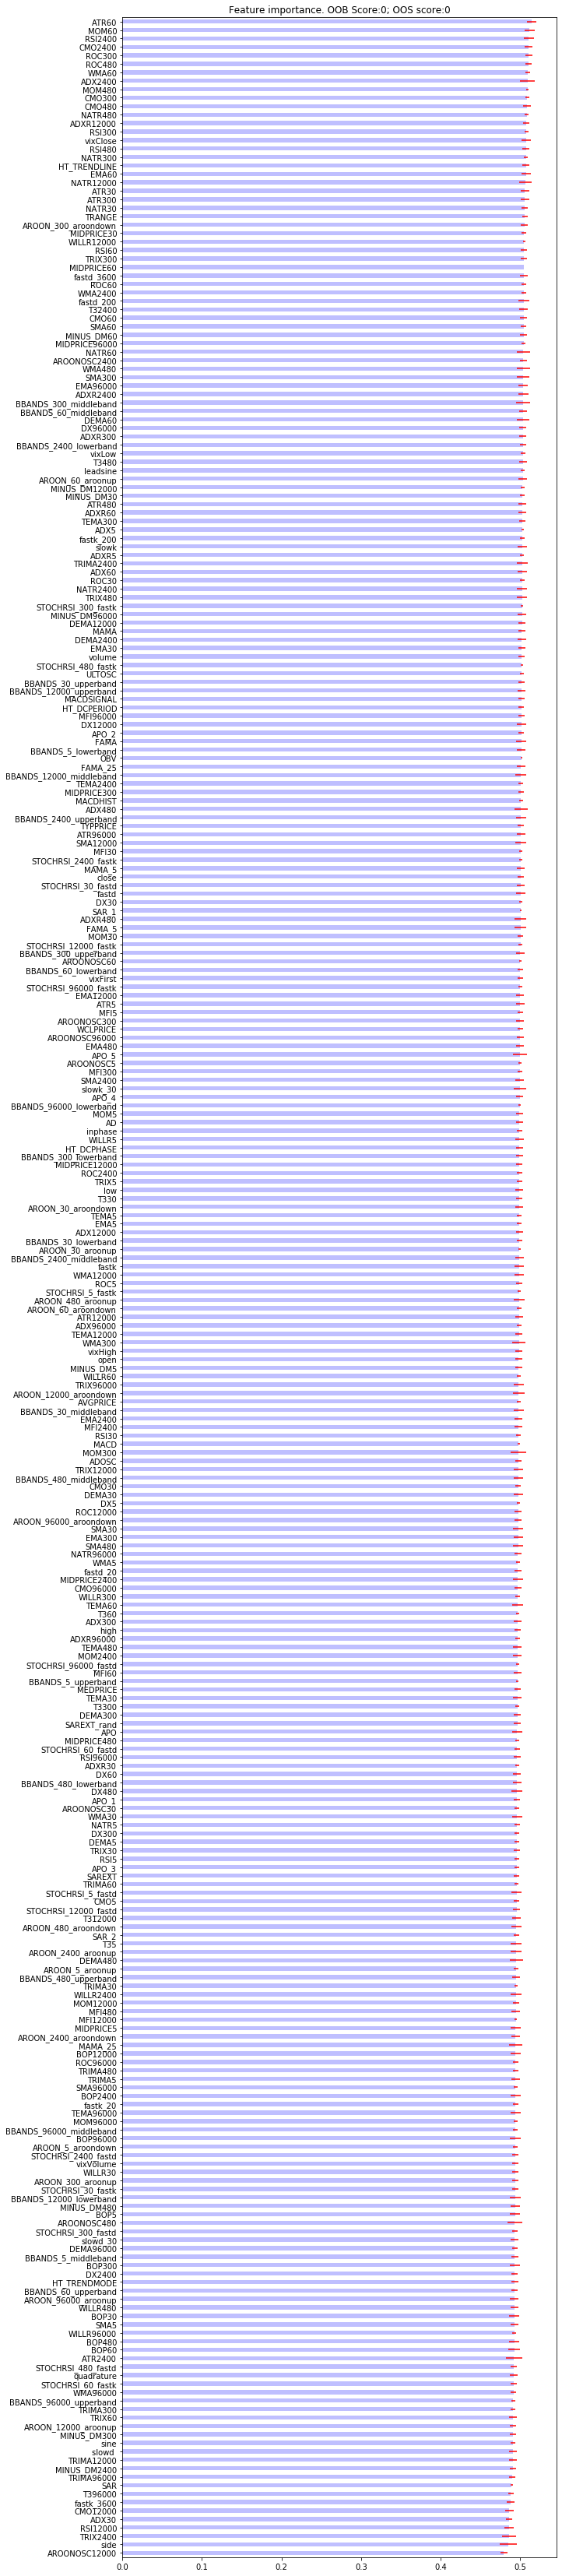

In [13]:
# single feature importance
ml.feature_importance.plot_feature_importance(
    sfi_feature_imp, 0, 0, save_fig=True,
    output_path='sfi_feat_imp.png')

In [14]:
# Shape values

# explain the model's predictions using SHAP
explainer = shap.TreeExplainer(model=rf_best, model_output='raw')
shap_values = explainer.shap_values(X_train)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [15]:
# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value[0], shap_values[0][0,:], X_train.iloc[0,:])

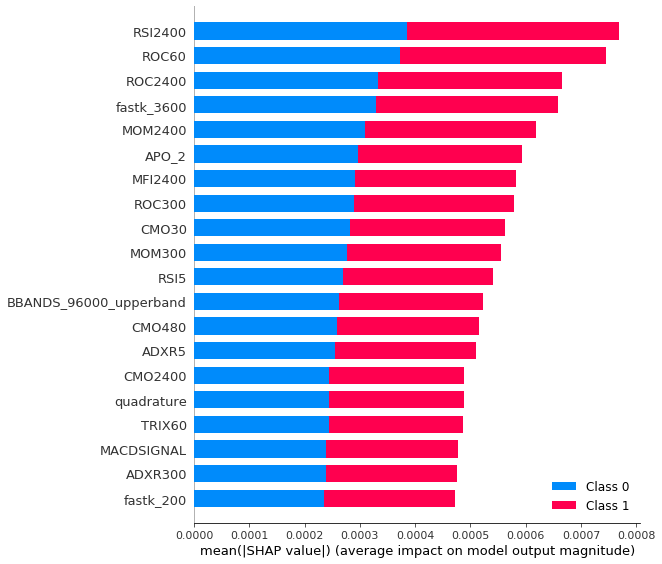

In [16]:
shap.summary_plot(shap_values, X_train, plot_type='bar')

### TRIPLE BARRIER WITHOUT PRIMARY MODEL

In [17]:
# Compute daily volatility
daily_vol = ml.util.get_daily_vol(close=spy['close_orig'], lookback=50)

# Apply Symmetric CUSUM Filter and get timestamps for events
cusum_events = ml.filters.cusum_filter(spy['close_orig'],
                                        threshold=daily_vol.mean())

# Compute vertical barrier
vertical_barriers = ml.labeling.add_vertical_barrier(t_events=cusum_events,
                                                        close=spy['close_orig'],
                                                        num_days=4200)
    

# make triple barriers (if side_prediction arg is omitted, return -1, 0, 1 
# (w/t which touched first))
pt_sl = [1, 1]  # IF ONLY SECONDARY (ML) MODEL HORIZONTAL BARRIERS SYMMETRIC!
min_ret = 0.005
triple_barrier_events = ml.labeling.get_events(
    close=spy['close_orig'],
    t_events=cusum_events,
    pt_sl=pt_sl,
    target=daily_vol,
    min_ret=min_ret,
    num_threads=1,
    vertical_barrier_times=vertical_barriers)
display(triple_barrier_events.head(10))

# labels
labels = ml.labeling.get_bins(triple_barrier_events, spy['close_orig'])
display(labels.head(10))
display(labels.bin.value_counts())
labels = ml.labeling.drop_labels(labels)
triple_barrier_events = triple_barrier_events.reindex(labels.index)

,t1,trgt,pt,sl
2003-09-23 08:43:00,2003-09-24 11:51:00,0.005241,1,1
2003-10-01 10:02:00,2003-10-01 13:16:00,0.005266,1,1
2003-10-01 10:10:00,2003-10-01 13:50:00,0.006510,1,1
2003-10-01 10:16:00,2003-10-01 13:58:00,0.006645,1,1
2003-10-01 10:28:00,2003-10-01 13:49:00,0.006283,1,1
2003-10-20 08:55:00,2003-10-20 16:35:00,0.006177,1,1
2003-10-20 09:38:00,2003-10-20 16:04:00,0.005002,1,1
2003-10-28 17:03:00,2003-10-28 17:04:00,0.006107,1,1
2003-10-28 17:04:00,2003-10-30 08:30:00,0.005986,1,1
2003-12-16 09:15:00,2003-12-16 15:26:00,0.005657,1,1


,ret,trgt,bin
2003-09-23 08:43:00,-0.005255,0.005241,-1
2003-10-01 10:02:00,0.005359,0.005266,1
2003-10-01 10:10:00,0.006850,0.006510,1
2003-10-01 10:16:00,0.006742,0.006645,1
2003-10-01 10:28:00,0.006653,0.006283,1
2003-10-20 08:55:00,0.006315,0.006177,1
2003-10-20 09:38:00,0.005080,0.005002,1
2003-10-28 17:03:00,0.029360,0.006107,1
2003-10-28 17:04:00,0.008013,0.005986,1
2003-12-16 09:15:00,0.005852,0.005657,1


-1    9214
 1    9207
Name: bin, dtype: int64

### Prepare model and calculate sample weights

In [18]:
# get data at triple-barrier evetns
X = spy.drop(columns=['close_orig']).reindex(labels.index)  # PROVJERITI OVO. MODA IPAK IDE TRIPPLE-BARRIER INDEX ???
y = labels['bin']
print('X shape: ', X.shape); print('y shape: ', y.shape)
print('y counts:\n', y.value_counts())

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.10, 
                                                    shuffle=False, 
                                                    stratify=None)
print(X_train.shape); print(y_train.shape)
print(X_test.shape); print(y_test.shape)


### SAMPLE WEIGHTS

return_sample_weights = ml.sample_weights.get_weights_by_return(
    triple_barrier_events.loc[X_train.index],
    spy.loc[X_train.index, 'close_orig'],
    num_threads=1)
time_sample_weights = ml.sample_weights.get_weights_by_time_decay(
    triple_barrier_events.loc[X_train.index],
    spy.loc[X_train.index, 'close_orig'],
    decay=0.5, num_threads=1)

X shape:  (18421, 300)
y shape:  (18421,)
y counts:
 -1    9214
 1    9207
Name: bin, dtype: int64
(16578, 300)
(16578,)
(1843, 300)
(1843,)


### Modeling

Confusion matrix train: 
[[4760 3540]
 [2640 5638]]
Confusion matrix test: 
[[656 258]
 [608 321]]
Accuracy train: 0.63
Accuracy test: 0.53
Recall train: 0.68
Recall test: 0.35
Precision train: 0.61
Precisoin test: 0.55
True values:  [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
Predictions:  [ 1 -1  1 -1  1 -1  1  1  1 -1]


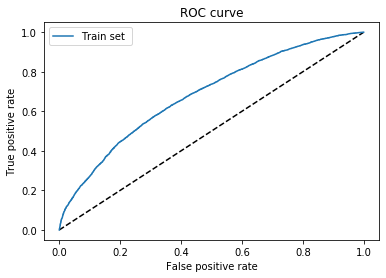

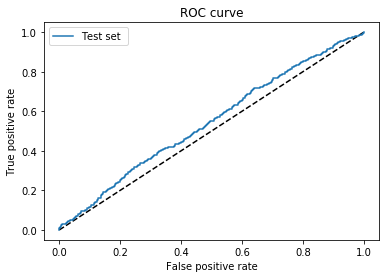

In [19]:
# parameters for GridSearch
parameters = {'max_depth': [2, 3, 4, 5, 10],
                'n_estimators': [600, 1000, 1400]}

# CV generators
cv_gen_purged = ml.cross_validation.PurgedKFold(
    n_splits=4,
    samples_info_sets=triple_barrier_events.reindex(X_train.index).t1)
rf = RandomForestClassifier(criterion='entropy',
                            max_features=10,
                            min_weight_fraction_leaf=0.05,
                            class_weight='balanced_subsample')
clf = GridSearchCV(rf,
                    param_grid=parameters,
                    scoring='f1',
                    n_jobs=8,
                    cv=cv_gen_purged)
clf.fit(X_train, y_train, sample_weight=time_sample_weights)
depth, n_estimators = clf.best_params_.values()
rf_best = RandomForestClassifier(criterion='entropy',
                                    max_features=1,
                                    min_weight_fraction_leaf=0.05,
                                    max_depth=depth,
                                    n_estimators=n_estimators,
                                    class_weight='balanced_subsample')
rf_best.fit(X_train, y_train, sample_weight=time_sample_weights)
tml.modeling.metrics_summary.display_clf_metrics(
    rf_best, X_train, X_test, y_train, y_test)
tml.modeling.metrics_summary.plot_roc_curve(
    rf_best, X_train, X_test, y_train, y_test)

### Feature importance

In [20]:
# mean decreasing impurity
mdi_feature_imp = ml.feature_importance.mean_decrease_impurity(
    rf_best, X_train.columns)

# mean decreasing accuracy
mda_feature_imp = ml.feature_importance.mean_decrease_accuracy(
    rf_best, X_train, y_train, cv_gen_purged,
    scoring=log_loss,
    sample_weight_train=return_sample_weights.values)

# single feature importance
# rf_best_ = clone(rf_best)  # seems sfi change learner somehow, and can't use it later
# sfi_feature_imp = ml.feature_importance.single_feature_importance(
#     rf_best_, X_train, y_train, cv_gen_purged,
#     scoring=accuracy_score,
#     sample_weight_train=return_sample_weights.values)

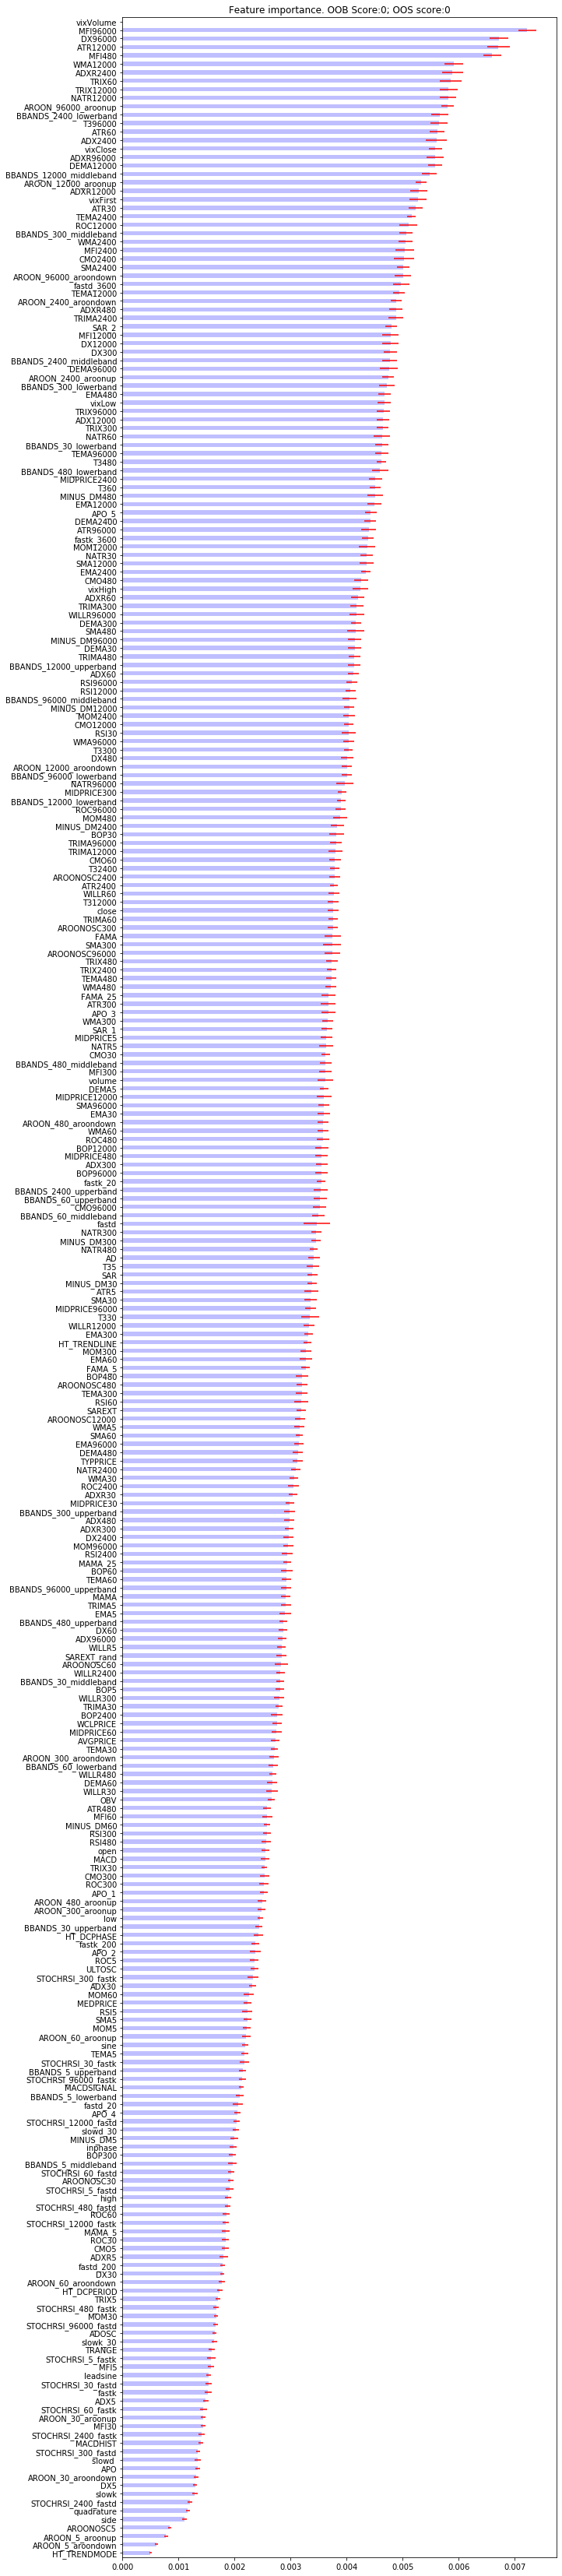

In [21]:
# mean decreasing impurity
ml.feature_importance.plot_feature_importance(
    mdi_feature_imp, 0, 0, save_fig=True,
    output_path='mdi_feat_imp.png')

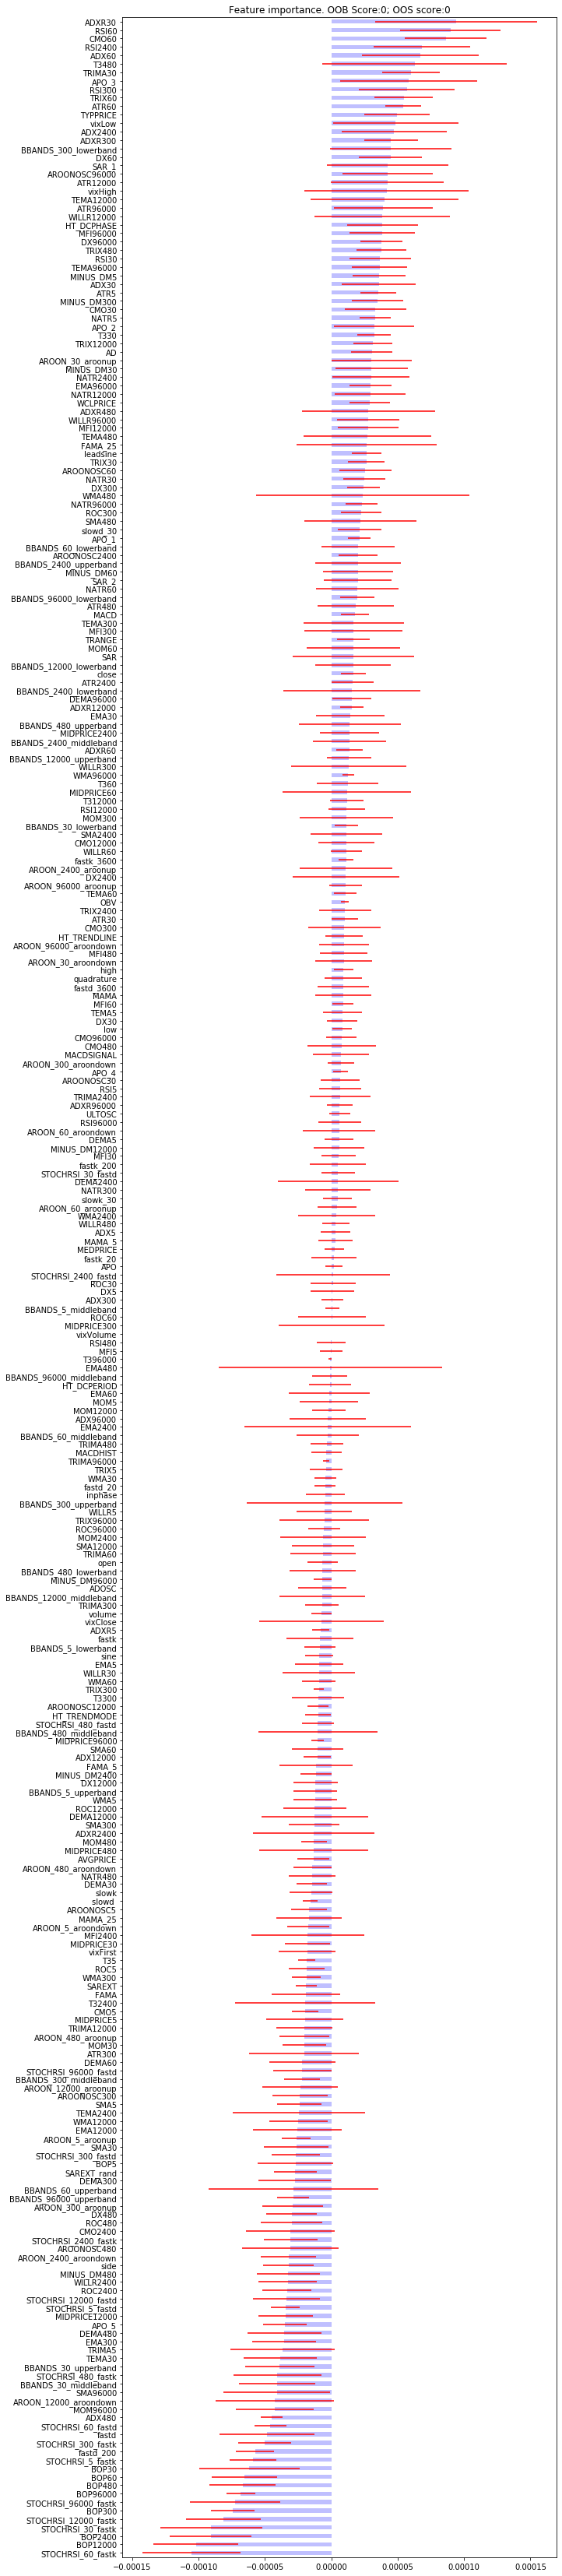

In [22]:
# mean decreasing accuracy
ml.feature_importance.plot_feature_importance(
    mda_feature_imp, 0, 0, save_fig=True,
    output_path='mda_feat_imp.png')

In [23]:
# # single feature importance
# ml.feature_importance.plot_feature_importance(
#     sfi_feature_imp, 0, 0, save_fig=True,
#     output_path='sfi_feat_imp.png')

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


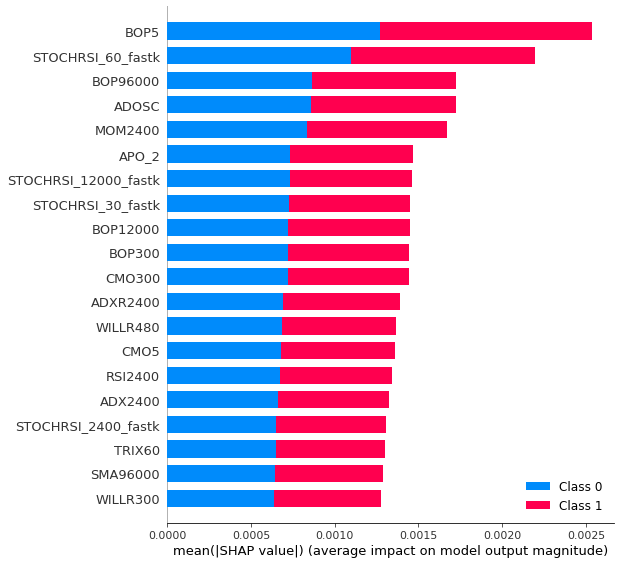

In [24]:
# Shape values

# explain the model's predictions using SHAP
explainer = shap.TreeExplainer(model=rf_best, model_output='raw')
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train, plot_type='bar')

### TREND SCANNING LABELING

In [26]:
from mlfinlab.structural_breaks.sadf import get_betas

def my_trend_scanning_labels(price_series: pd.Series, t_events: list = None, look_forward_window: int = 20,
                          min_sample_length: int = 5, step: int = 1) -> pd.DataFrame:
    """
    `Trend scanning <https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3257419>`_ is both a classification and
    regression labeling technique.
    That can be used in the following ways:
    1. Classification: By taking the sign of t-value for a given observation we can set {-1, 1} labels to define the
       trends as either downward or upward.
    2. Classification: By adding a minimum t-value threshold you can generate {-1, 0, 1} labels for downward, no-trend,
       upward.
    3. The t-values can be used as sample weights in classification problems.
    4. Regression: The t-values can be used in a regression setting to determine the magnitude of the trend.
    The output of this algorithm is a DataFrame with t1 (time stamp for the farthest observation), t-value, returns for
    the trend, and bin.
    :param price_series: (pd.Series) close prices used to label the data set
    :param t_events: (list) of filtered events, array of pd.Timestamps
    :param look_forward_window: (int) maximum look forward window used to get the trend value
    :param min_sample_length: (int) minimum sample length used to fit regression
    :param step: (int) optimal t-value index is searched every 'step' indices
    :return: (pd.DataFrame) of t1, t-value, ret, bin (label information). t1 - label endtime, tvalue,
        ret - price change %, bin - label value based on price change sign
    """
    # pylint: disable=invalid-name

    if t_events is None:
        t_events = price_series.index

    t1_array = []  # Array of label end times
    t_values_array = []  # Array of trend t-values

    for index in t_events:
        subset = price_series.loc[index:].iloc[:look_forward_window]  # Take t:t+L window
        if subset.shape[0] >= look_forward_window:
            # Loop over possible look-ahead windows to get the one which yields maximum t values for b_1 regression coef
            max_abs_t_value = -np.inf  # Maximum abs t-value of b_1 coefficient among l values
            max_t_value_index = None  # Index with maximum t-value
            max_t_value = None  # Maximum t-value signed

            # Get optimal label end time value based on regression t-statistics
            for forward_window in np.arange(min_sample_length, subset.shape[0], step):
                y_subset = subset.iloc[:forward_window].values.reshape(-1, 1)  # y{t}:y_{t+l}

                # Array of [1, 0], [1, 1], [1, 2], ... [1, l] # b_0, b_1 coefficients
                X_subset = np.ones((y_subset.shape[0], 2))
                X_subset[:, 1] = np.arange(y_subset.shape[0])

                # Get regression coefficients estimates
                b_mean_, b_std_ = get_betas(X_subset, y_subset)
                # Check if l gives the maximum t-value among all values {0...L}
                t_beta_1 = (b_mean_[1] / np.sqrt(b_std_[1, 1]))[0]
                if abs(t_beta_1) > max_abs_t_value:
                    max_abs_t_value = abs(t_beta_1)
                    max_t_value = t_beta_1
                    max_t_value_index = forward_window

            # Store label information (t1, return)
            label_endtime_index = subset.index[max_t_value_index - 1]
            t1_array.append(label_endtime_index)
            t_values_array.append(max_t_value)

        else:
            t1_array.append(None)
            t_values_array.append(None)

    labels = pd.DataFrame({'t1': t1_array, 't_value': t_values_array}, index=t_events)
    labels.loc[:, 'ret'] = price_series.reindex(labels.t1).values / price_series.reindex(labels.index).values - 1
    labels['bin'] = np.sign(labels.t_value)

    return labels

In [ ]:
# trend scanning on cusum events
n_days = 60 * 8 * 15  # (10 days)
labels = my_trend_scanning_labels(
    price_series=spy['close_orig'],
    t_events=spy.index,
    look_forward_window=n_days,
    min_sample_length=30,
    step=10
)

In [ ]:
# remove nan from matrix
labels_clean = labels.dropna()

# check balance of labels
labels_clean.bin.value_counts()

### Prepare model

In [ ]:
# define X and y sets
X = spy.drop(columns=['close_orig']).reindex(labels_clean.index)
y = labels_clean['bin']
print('X shape: ', X.shape); print('y shape: ', y.shape)
print('y counts:\n', y.value_counts())

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.10, 
                                                    shuffle=False, 
                                                    stratify=None)
print(X_train.shape); print(y_train.shape)
print(X_test.shape); print(y_test.shape)

# Što dalje?

### Podaci

1. Kupnja **ticker podataka**. Osnovna prednost ticker podataka je mogućnost kreiranja *barova* sa boljim statističkim sovjstvima u odnosu na vremenske *barove*. Primjer su ticker/volumen/dolar *barovi* i nebalansirani *batovi*. Nedostatak je cijena, velika količina podataka i update podataka.
2. Razmisliti o korištenju ***microstructure* podataka**. Oni pružaju dodatne informacije uz OHLC, primjerice broj danih naloga, broj zatvorenih naloga i sl. Lista indikatora:
https://mlfinlab.readthedocs.io/en/develop/implementations/microstructural_features.html#
3. Korištenje **pojedinačnih dionica**, kako bi se proširio uzorak i pronašao obrazac koji je robustan na raličiti skup dionica.
4. Analiza **fundamenata** pojedinih dionica (faktorski modeli).
5. Podaci iz vijesti ili tweetova. Općenito **web scraping** poznatih stranica sa predviđanjima i tekstovima o dionicama. MOgao bi se kao primjer uzeti jedan news portal, probati zascrapit sadržaj za n dana unazad i probati napraviti predikcijski ML model sa vijestima kao inputom.

### Vrsta analize

1. Do sada je naglasak bio na tržišnim podacima i srednje visokom frekventnom trgovanju. U budućnosti bi valjalo proširiti analizu na takozvanu faktor analitu, koja koristi funadmentalne i ostale podatke o firmama.
2. Korak dalje bi bio i korištenje alternativnih poddataka za *nowcasting*.
3. Proširiti analizu na veći uinvezum dionica /ili klasa imovine (zlato, kriptovalute itd.)

### Modeliranje

1. Staviti veći ponder na regresijske modele (za sada smo se uglavnom fokusriali na klasifikaciju).
2. Napraviti pipeline koji uključuje seve korake!
3. Fine tuning cijelog pipelina pomoću grid/random searcha ili bayesovih metoda
4. Detaljnije isprobati neuronske mreže

### Mjere rizika

1. Izračunati mjere rizika za sve tipove imovine (SPY ili drugi tipovi) poputs Var, očekivano *shortfalla* itd

### Literatura za proći

1. Machine learning for factor investing (https://github.com/shokru/mlfactor.github.io)
2. Machine Learning in Finance (https://www.springer.com/gp/book/9783030410674#aboutBook)